In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [85]:
# Constants
BOARD_SIZE = 10
SHIP_SIZES = [5, 4, 3, 3, 2]  # Carrier, Battleship, Cruiser, Submarine, Destroyer

class Board:
    def __init__(self, size=BOARD_SIZE, ship_sizes=SHIP_SIZES):
        self.size = size
        self.ship_sizes = ship_sizes
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self._place_ships()
        self.hits = set()

    def _place_ships(self):
        self.ship_coords = []
        for length in self.ship_sizes:
            placed = False
            while not placed:
                horizontal = np.random.rand() < 0.5
                if horizontal:
                    row = np.random.randint(0, self.size)
                    col = np.random.randint(0, self.size - length + 1)
                    coords = [(row, c) for c in range(col, col + length)]
                else:
                    row = np.random.randint(0, self.size - length + 1)
                    col = np.random.randint(0, self.size)
                    coords = [(r, col) for r in range(row, row + length)]
                if all(self.grid[r, c] == 0 for r, c in coords):
                    for r, c in coords:
                        self.grid[r, c] = 1
                    self.ship_coords.append(set(coords))
                    placed = True

    def shoot(self, pos):
        r, c = pos
        if pos in self.hits:
            return 'repeat'
        self.hits.add(pos)
        if self.grid[r, c] == 1:
            for ship in self.ship_coords:
                if pos in ship:
                    ship.remove(pos)
                    if not ship:
                        return 'sunk'
                    return 'hit'
        return 'miss'

    def all_sunk(self):
        return all(len(ship) == 0 for ship in self.ship_coords)


# Plotting helpers
def plot_board(grid, shot_results, title, show_ships):
    ax = plt.gca()
    ax.clear()
    ax.set_xticks(np.arange(-.5, BOARD_SIZE, 1))
    ax.set_yticks(np.arange(-.5, BOARD_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    if show_ships:
        for (r, c), val in np.ndenumerate(grid):
            if val == 1:
                ax.add_patch(plt.Rectangle((c - .5, r - .5), 1, 1, fill=True,
                                            edgecolor='black', facecolor='lightgray'))
    for (r, c), res in shot_results.items():
        color = 'red' if res in ('hit', 'sunk') else 'blue'
        ax.text(c, r, 'X', ha='center', va='center', color=color, fontsize=12)
    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.draw()
    plt.pause(0.001)

In [87]:
class BaseAgent:
    def __init__(self):
        self.reset()

    def reset(self):
        self.shots = []
        self.hits = set()
        self.misses = set()

    def next_shot(self):
        raise NotImplementedError

    def update(self, pos, result):
        if result == 'hit' or result == 'sunk':
            self.hits.add(pos)
        elif result == 'miss':
            self.misses.add(pos)


class RandomAgent(BaseAgent):
    def next_shot(self):
        candidates = [(r, c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE) if (r, c) not in self.shots]
        choice = candidates[np.random.randint(len(candidates))]
        self.shots.append(choice)
        return choice

# TODO: Implement GridAgent, PDFAgent, GPAAgent, MCTSAgent, NNAgent skeletons

# Simulation functions
def play_game(agent, board=None):
    if board is None:
        board = Board()
    board.reset()
    agent.reset()
    turns = 0
    while not board.all_sunk():
        pos = agent.next_shot()
        result = board.shoot(pos)
        agent.update(pos, result)
        turns += 1
    return turns

In [89]:
class GridAgent(BaseAgent):
    def reset(self):
        super().reset()
        self.mode = 'hunt'
        # Only shoot on cells where (row+col) is odd
        self.hunt_cells = [(r, c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE) if (r + c) % 2 == 1]
        np.random.shuffle(self.hunt_cells)
        self.origin = None
        self.direction = None
        self.tried_dirs = []
        self.next_target = None

    def next_shot(self):
        # HUNT MODE
        if self.mode == 'hunt':
            if self.hunt_cells:
                shot = self.hunt_cells.pop()
            else:
                # Fallback: shoot any remaining cell
                candidates = [(r, c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE) if (r, c) not in self.shots]
                shot = candidates[np.random.randint(len(candidates))]
            self.shots.append(shot)
            return shot

        # TARGET MODE
        # Try directions around origin until ship is sunk
        while self.mode == 'target':
            # pick new direction if needed
            if self.next_target is None:
                # if all dirs tried, abort back to hunt
                all_dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]
                if set(self.tried_dirs) >= set(all_dirs):
                    # no more directions, reset
                    self.mode = 'hunt'
                    return self.next_shot()
                # select next untried dir
                for dx, dy in all_dirs:
                    if (dx, dy) not in self.tried_dirs:
                        self.direction = (dx, dy)
                        self.next_target = (self.origin[0] + dx, self.origin[1] + dy)
                        break
            r, c = self.next_target
            # check valid
            if not (0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE) or self.next_target in self.shots:
                # mark miss on this direction and pick next
                self.tried_dirs.append(self.direction)
                self.direction = None
                self.next_target = None
                continue
            # valid shot
            shot = self.next_target
            self.shots.append(shot)
            return shot

    def update(self, pos, result):
        if self.mode == 'hunt':
            if result == 'hit':
                self.mode = 'target'
                self.origin = pos
                self.tried_dirs = []
                self.direction = None
                self.next_target = None
            return

        # TARGET MODE UPDATE
        if result == 'hit':
            dx, dy = self.direction
            # continue in same direction
            self.next_target = (pos[0] + dx, pos[1] + dy)
        elif result == 'miss':
            # mark this dir tried and reset next_target
            self.tried_dirs.append(self.direction)
            self.direction = None
            self.next_target = None
        elif result == 'sunk':
            # ship down, go back to hunt
            self.mode = 'hunt'
            self.origin = None
            self.direction = None
            self.tried_dirs = []
            self.next_target = None

In [91]:
class PDFAgent(BaseAgent):
    def __init__(self):
        super().__init__()

    def reset(self):
        super().reset()
        # Use full ship list each game
        self.remaining_sizes = list(SHIP_SIZES)

    def next_shot(self):
        # Build heatmap
        heatmap = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        for length in self.remaining_sizes:
            # horizontal placements
            for r in range(BOARD_SIZE):
                for c in range(BOARD_SIZE - length + 1):
                    coords = [(r, c+i) for i in range(length)]
                    if any(pos in self.misses for pos in coords):
                        continue
                    if self.hits and not any(pos in self.hits for pos in coords):
                        continue
                    for pos in coords:
                        heatmap[pos] += 1
            # vertical placements
            for c in range(BOARD_SIZE):
                for r in range(BOARD_SIZE - length + 1):
                    coords = [(r+i, c) for i in range(length)]
                    if any(pos in self.misses for pos in coords):
                        continue
                    if self.hits and not any(pos in self.hits for pos in coords):
                        continue
                    for pos in coords:
                        heatmap[pos] += 1
        # Mask already shot
        for pos in self.shots:
            heatmap[pos] = -1
        # Pick max
        idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        self.shots.append(idx)
        return idx

    def update(self, pos, result):
        super().update(pos, result)
        if result == 'sunk':
            # approximate: remove a ship of that length from remaining
            # count contiguous hits to estimate length
            sunk_length = 1
            around = [(1,0),(-1,0),(0,1),(0,-1)]
            for dx,dy in around:
                if (pos[0]+dx,pos[1]+dy) in self.hits:
                    sunk_length += 1
            if sunk_length in self.remaining_sizes:
                self.remaining_sizes.remove(sunk_length)

In [103]:

class MCTSAgent(BaseAgent):
    def __init__(self, simulations_per_move=100, exploration=1.41):
        super().__init__()
        self.simulations = simulations_per_move
        self.exploration = exploration

    def next_shot(self, board):
        # initialize stats for each legal move
        candidates = [(r, c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)
                      if (r, c) not in self.shots]
        stats = {move: {'visits': 0, 'total': 0} for move in candidates}
        for _ in range(self.simulations):
            # Select move via UCB1
            if any(stats[move]['visits'] == 0 for move in candidates):
                move = next(m for m in candidates if stats[m]['visits'] == 0)
            else:
                total_visits = sum(stats[m]['visits'] for m in candidates)
                ucb_scores = {}
                for m in candidates:
                    s = stats[m]
                    mean = s['total'] / s['visits']
                    ucb = mean + self.exploration * np.sqrt(np.log(total_visits) / s['visits'])
                    ucb_scores[m] = ucb
                move = max(ucb_scores, key=ucb_scores.get)
            # simulate playout
            sim_board = board.clone()
            sim_agent = RandomAgent()
            sim_agent.shots = list(self.shots)
            sim_agent.hits = set(self.hits)
            sim_agent.misses = set(self.misses)
            # apply candidate move
            res = sim_board.shoot(move)
            sim_agent.update(move, res)
            turns = 1
            while not sim_board.all_sunk():
                shot = sim_agent.next_shot(sim_board)
                r = sim_board.shoot(shot)
                sim_agent.update(shot, r)
                turns += 1
            # update stats: lower turns is better
            stats[move]['visits'] += 1
            stats[move]['total'] += -turns  # reward = negative turns
        # pick move with best average reward
        best_move = max(candidates, key=lambda m: stats[m]['total'] / stats[m]['visits'])
        return best_move

In [113]:
class HeatMapAgent(BaseAgent):
    """
    Generates all possible full board layouts consistent with hits/misses,
    maintains possibleStates, and re-computes heatmap probabilities each turn.
    """
    def __init__(self):
        super().__init__()
        self.possible_states = []

    def reset(self):
        super().reset()
        # Generate all possible ship placements matrices
        self.possible_states = self._generate_all_states()

    def _generate_all_states(self):
        # brute-force generate all placements for each ship and combine
        # for 10x10 with 17 tiles this is huge; this is illustrative only
        # returns list of full-board grids (numpy arrays)
        states = []
        # helper: recursively place ships
        def place_next(grid, ships, idx=0):
            if idx == len(ships):
                states.append(grid.copy())
                return
            length = ships[idx]
            for r in range(BOARD_SIZE):
                for c in range(BOARD_SIZE - length + 1):
                    sub = grid[r, c:c+length]
                    if np.all(sub == 0):
                        grid[r, c:c+length] = 1
                        place_next(grid, ships, idx+1)
                        grid[r, c:c+length] = 0
            for r in range(BOARD_SIZE - length + 1):
                for c in range(BOARD_SIZE):
                    sub = grid[r:r+length, c]
                    if np.all(sub == 0):
                        grid[r:r+length, c] = 1
                        place_next(grid, ships, idx+1)
                        grid[r:r+length, c] = 0
        place_next(np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int), SHIP_SIZES)
        return states

    def _filter_states(self):
        new_states = []
        for state in self.possible_states:
            ok = True
            for pos in self.hits:
                if state[pos] != 1:
                    ok = False; break
            if not ok: continue
            for pos in self.misses:
                if state[pos] == 1:
                    ok = False; break
            if ok:
                new_states.append(state)
        self.possible_states = new_states

    def next_shot(self, board=None):
        # filter based on latest move
        self._filter_states()
        # compute heatmap
        heatmap = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        for state in self.possible_states:
            heatmap += state
        # mask already-shot
        for pos in self.shots:
            heatmap[pos] = -1
        # normalize to probabilities
        if len(self.possible_states) > 0:
            heatmap = heatmap / len(self.possible_states)
        # pick highest chance
        idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        self.shots.append(idx)
        return idx

In [125]:
# TODO: Implement PDFAgent, GPAAgent, MCTSAgent, NNAgent skeletons

# Simulation functions
def play_game(agent, board=None):
    if board is None:
        board = Board()
    board.reset()
    agent.reset()
    turns = 0
    while not board.all_sunk():
        pos = agent.next_shot()
        result = board.shoot(pos)
        agent.update(pos, result)
        turns += 1
    return turns

if __name__ == '__main__':
    MODELS = [
        ('Random', RandomAgent()),
        ('Grid', GridAgent()),
        ('PDF', PDFAgent()),
        # ('GP', GPAAgent()),
        # ('MCTS', MCTSAgent()),
        # ('NN', NNAgent()),
        ('HeatMap', HeatMapAgent()),
    ]
    results = {}
    total_turns = []
    for name, agent in MODELS:
        turns_list = []
        for _ in tqdm(range(1000), desc=f"Simulating {name}"):
            if name == 'MCTS':
                turns = play_game(agent)
            else:
                turns = play_game(agent)
            turns_list.append(turns)
        results[name] = np.mean(turns_list)
        total_turns.append(turns_list)

    # Plotting
    names = list(results.keys())
    values = [results[n] for n in names]
    plt.figure()
    plt.bar(names, values)
    plt.ylabel('Average Turns to Sink All')
    plt.title('Battleship Agent Performance')
    plt.show()


MemoryError: 

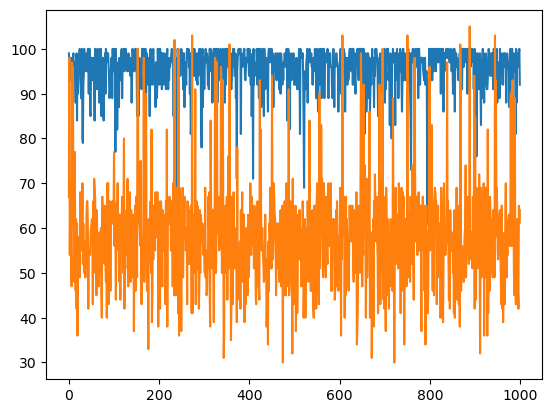

In [49]:
# Extra Plots
plt.plot(np.arange(1000), total_turns[0], total_turns[1])
plt.show() 

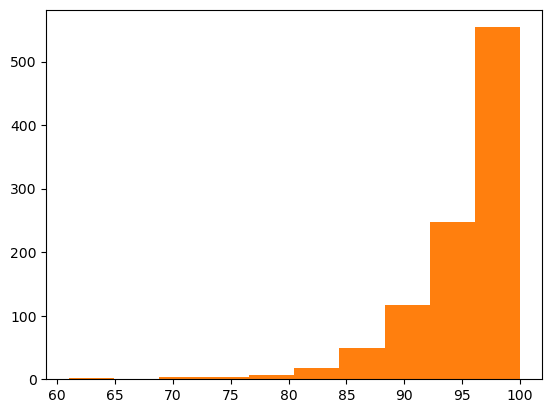

In [53]:
plt.hist(total_turns[0])
plt.show() 

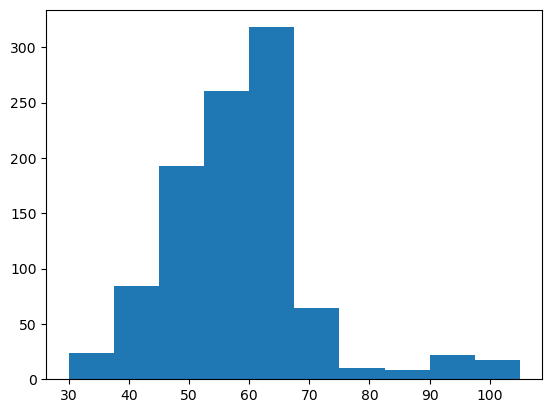

In [59]:
plt.hist(total_turns[1])
plt.show()

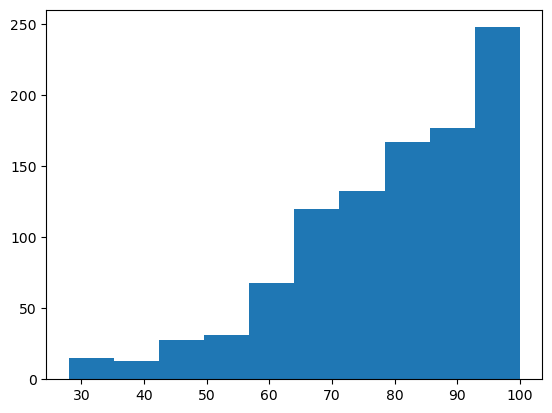

In [65]:
plt.hist(total_turns[2])
plt.show()

In [107]:

# Simulation and animation

def simulate_and_plot(agent, show_ships=False):
    board = Board()
    board.reset()
    agent.reset()
    shot_results = {}
    while not board.all_sunk():
        pos = agent.next_shot()
        result = board.shoot(pos)
        agent.update(pos, result)
        shot_results[pos] = result
    plt.figure(figsize=(6,6))
    plot_board(board.grid, shot_results,
               f"{agent.__class__.__name__} Simulation ({len(shot_results)} shots)",
               show_ships)
    plt.show()


def simulate_with_steps(agent, show_ships=False, pause=0.5):
    board = Board()
    board.reset()
    agent.reset()
    shot_results = {}
    plt.ion()
    fig = plt.figure(figsize=(6,6))
    for turn in range(BOARD_SIZE * BOARD_SIZE):
        if board.all_sunk():
            break
        pos = agent.next_shot()
        result = board.shoot(pos)
        agent.update(pos, result)
        shot_results[pos] = result
        plot_board(board.grid, shot_results,
                   f"{agent.__class__.__name__} Turn {turn+1}",
                   show_ships)
        plt.pause(pause)
    plt.ioff()
    plt.show()


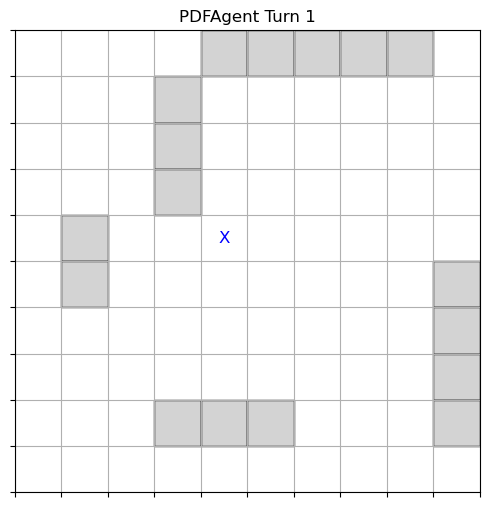

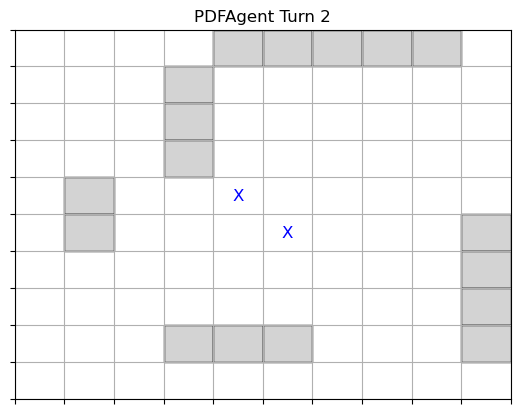

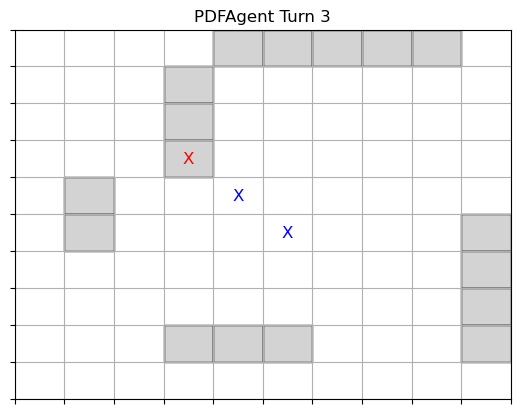

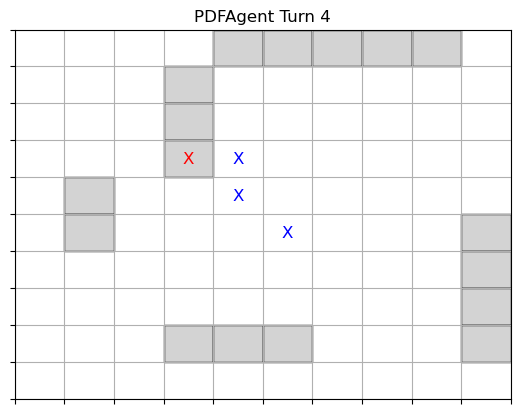

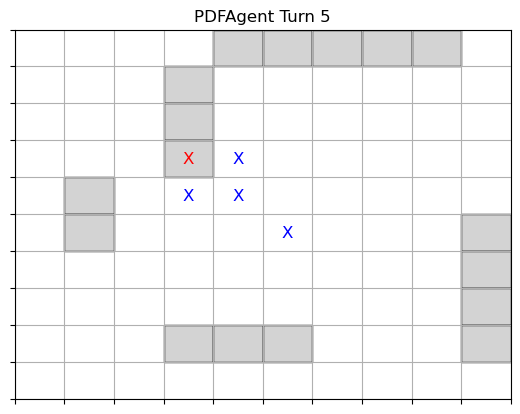

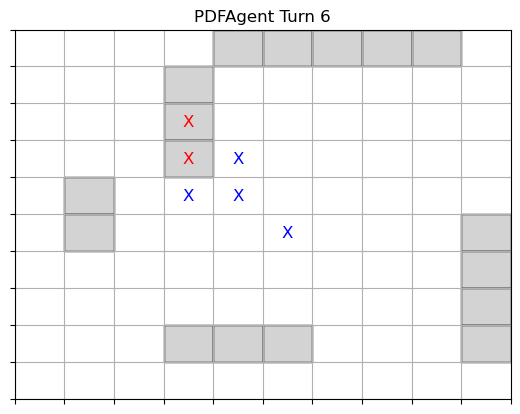

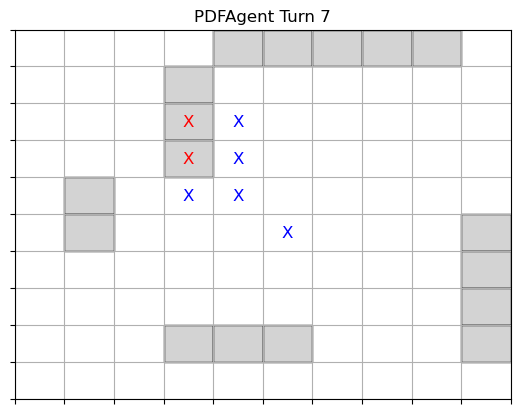

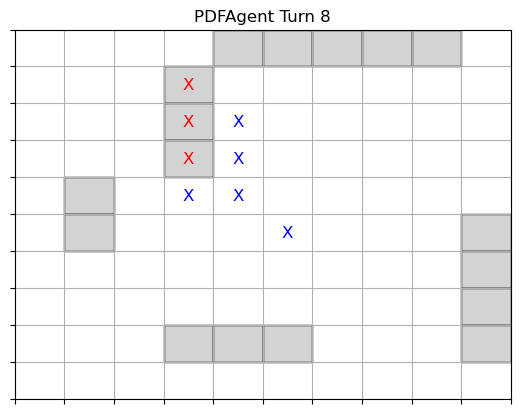

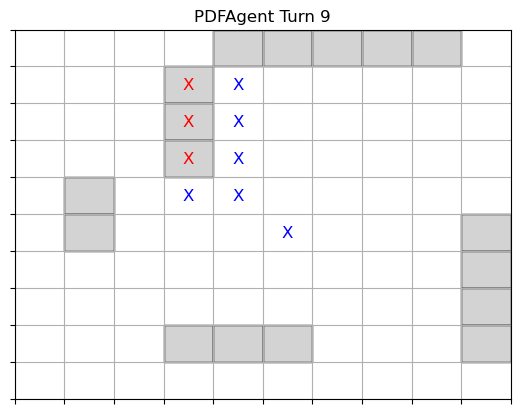

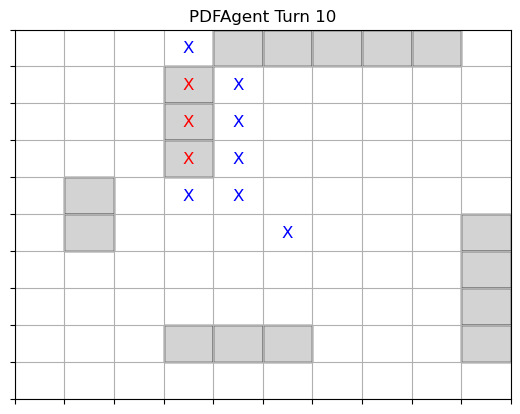

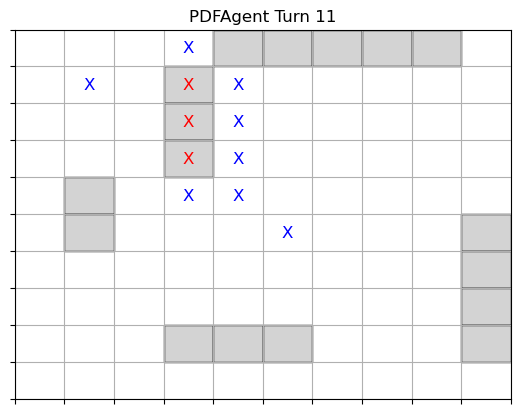

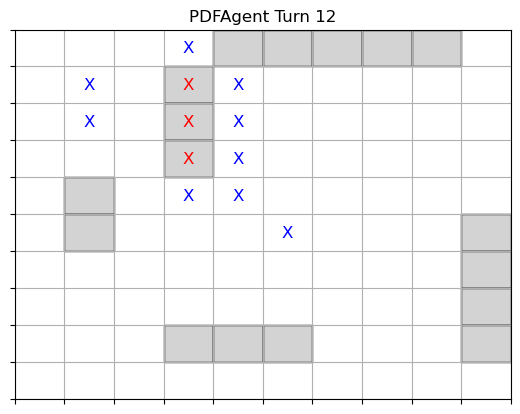

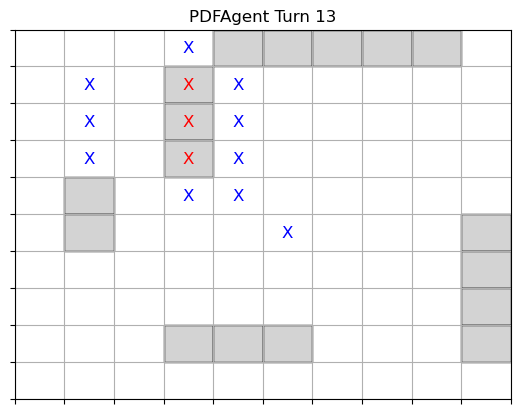

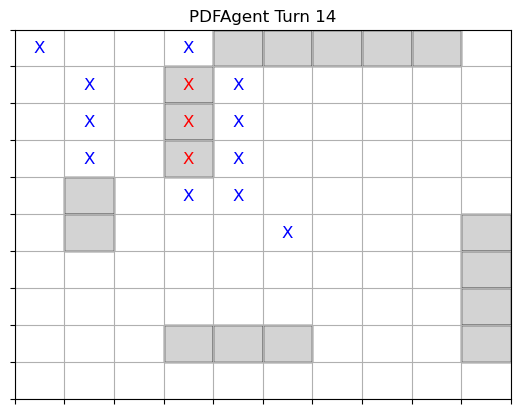

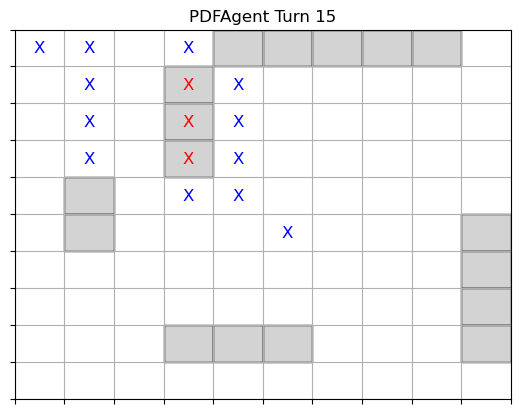

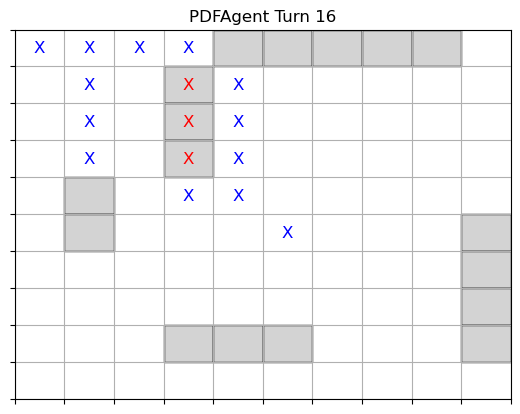

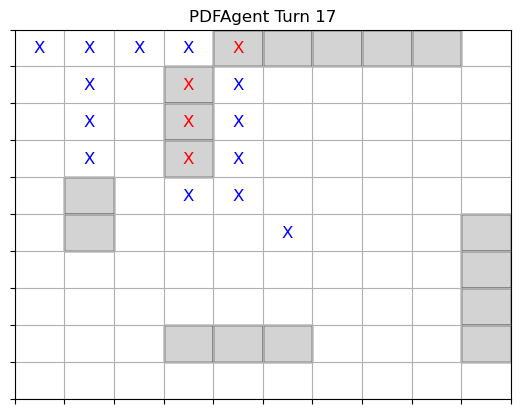

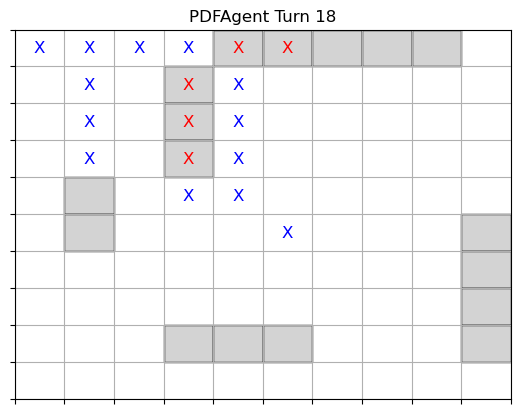

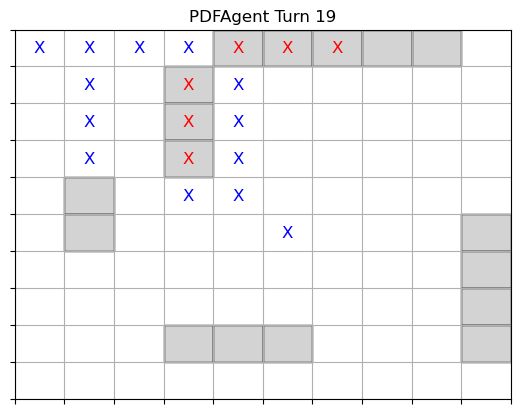

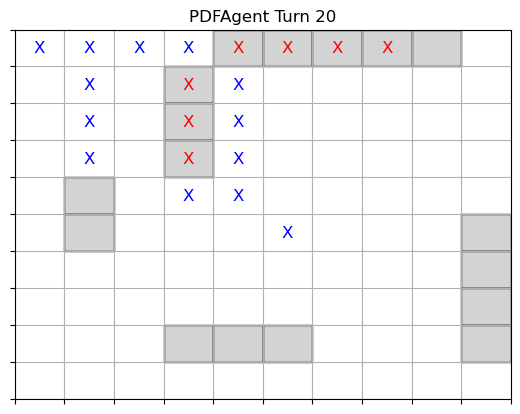

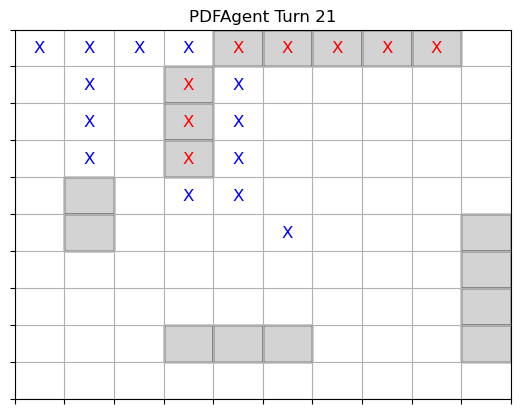

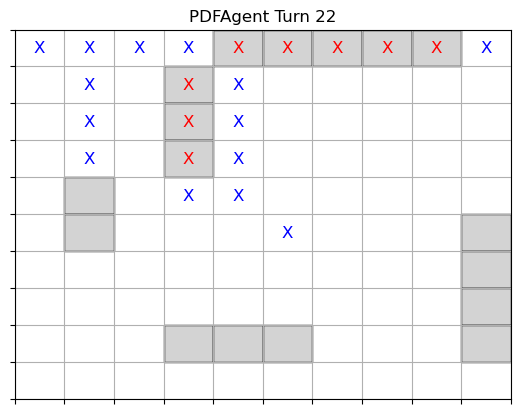

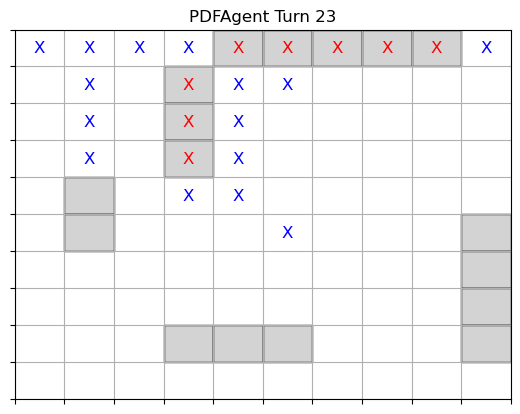

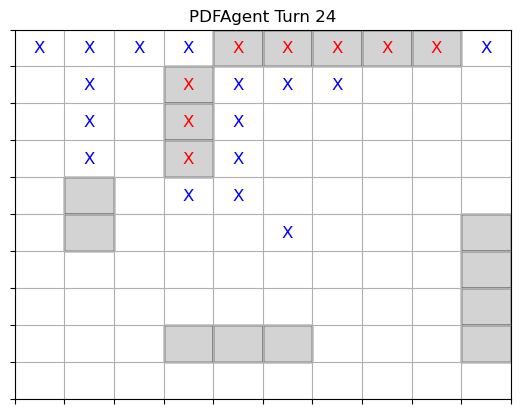

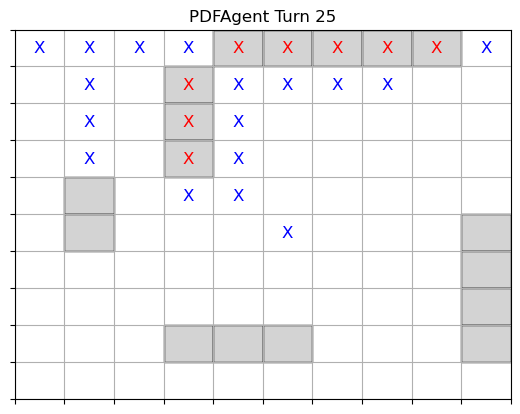

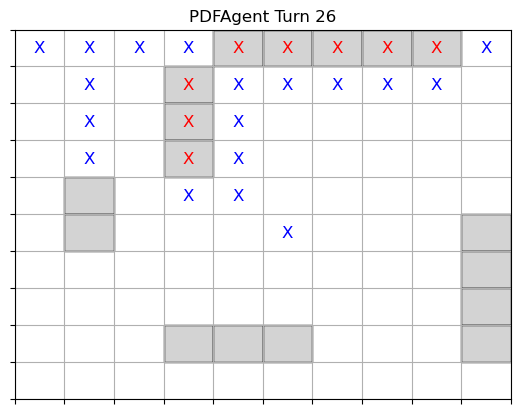

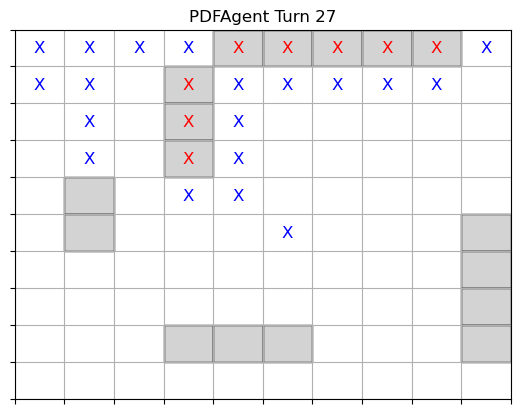

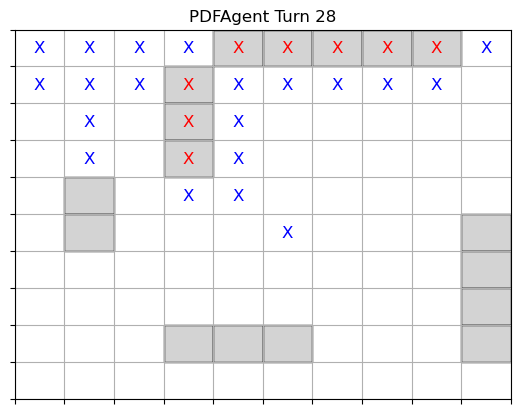

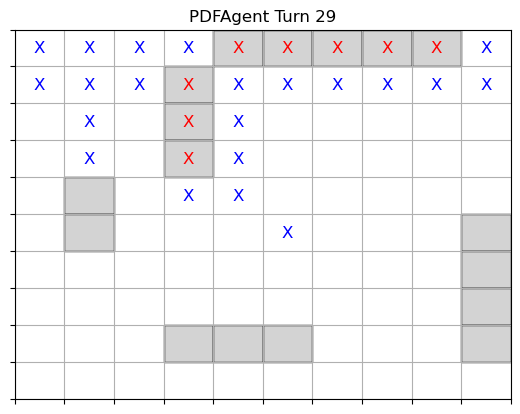

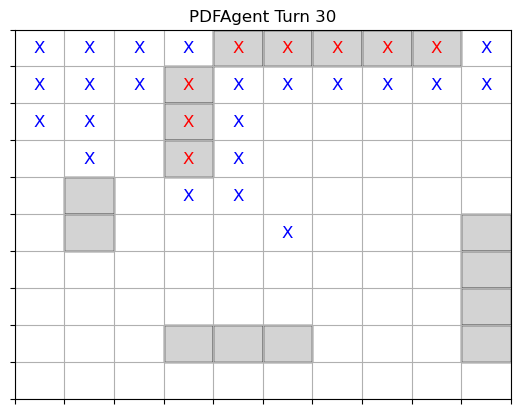

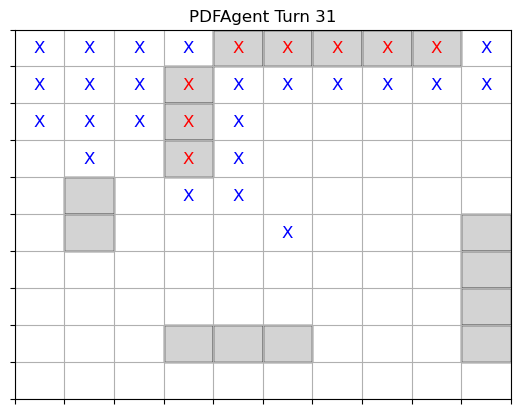

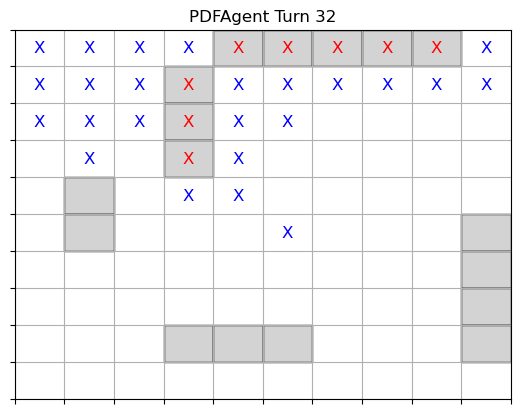

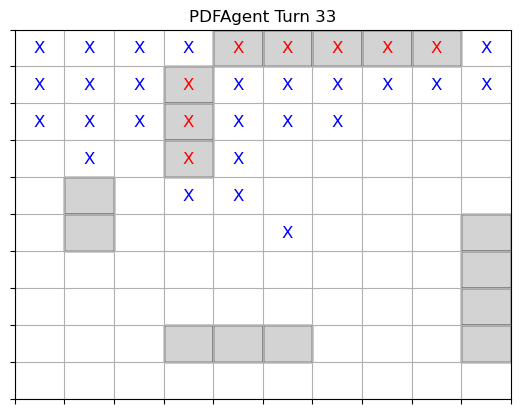

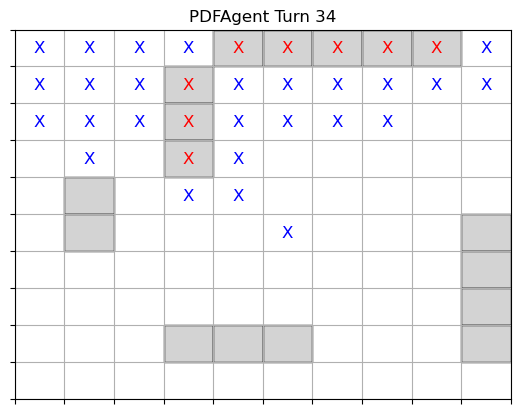

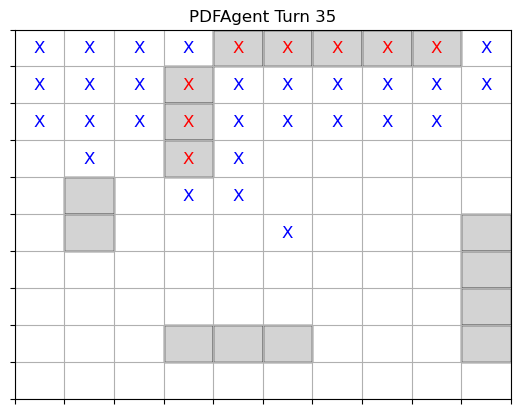

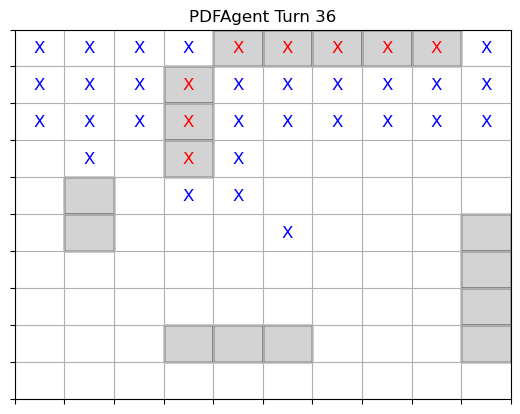

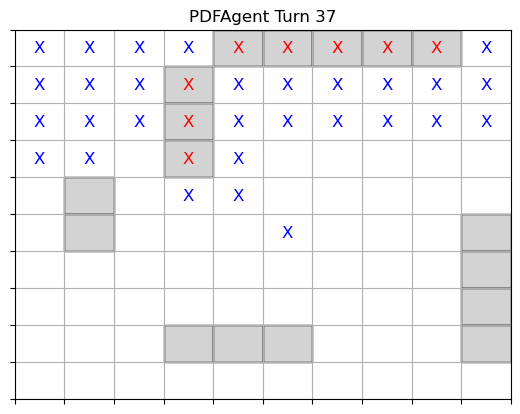

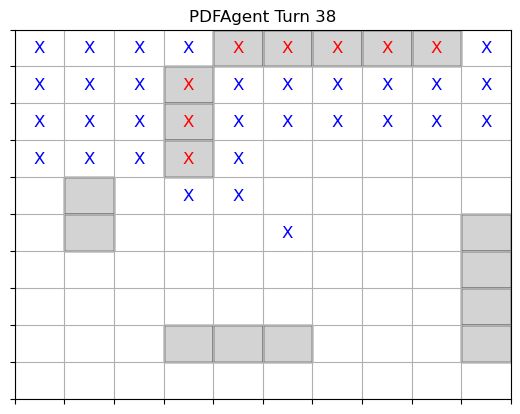

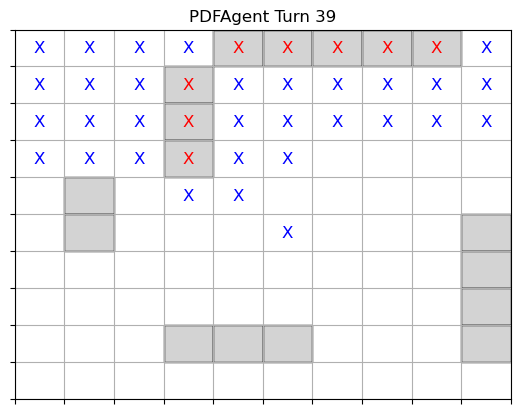

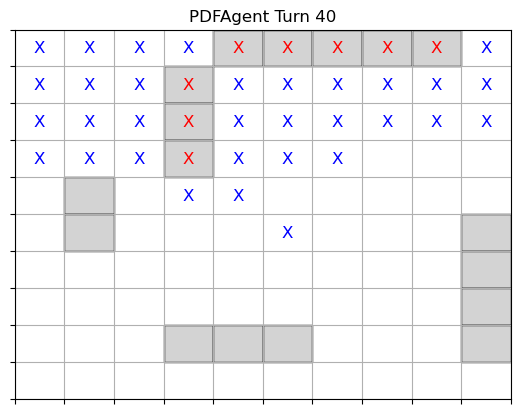

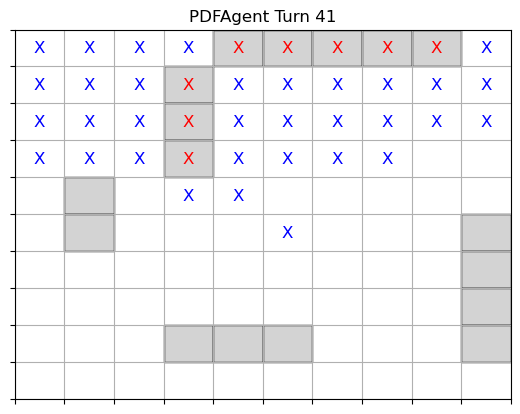

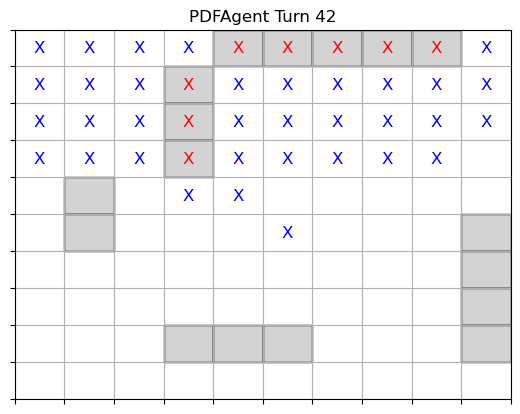

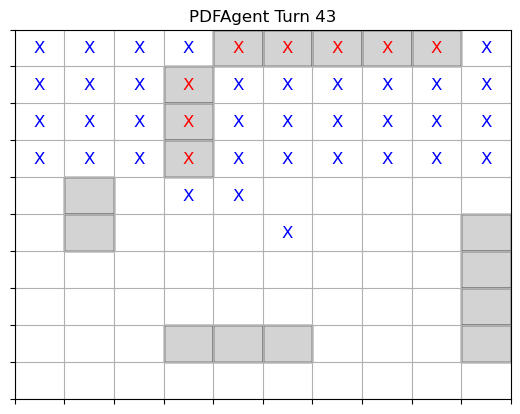

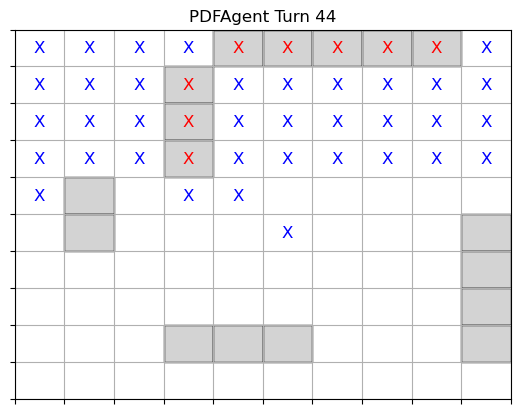

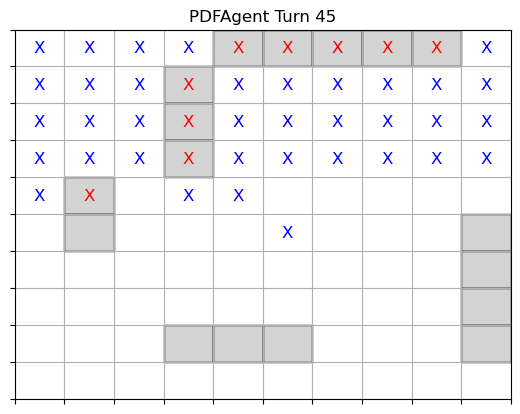

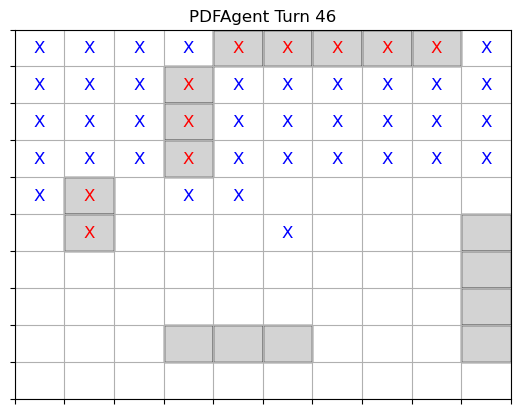

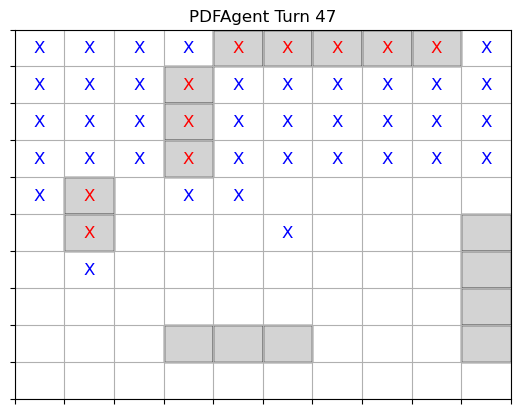

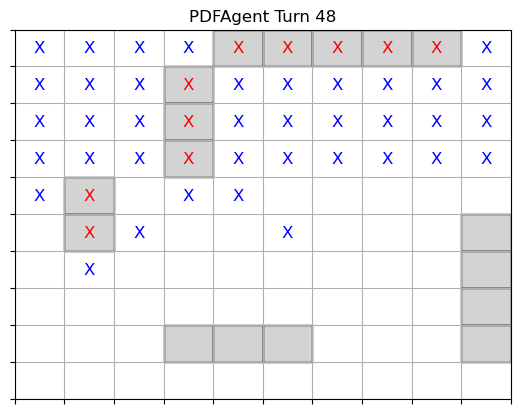

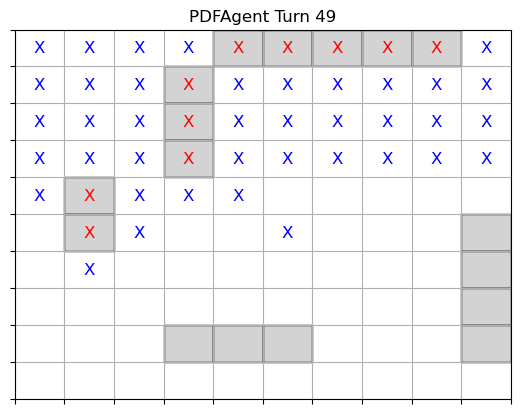

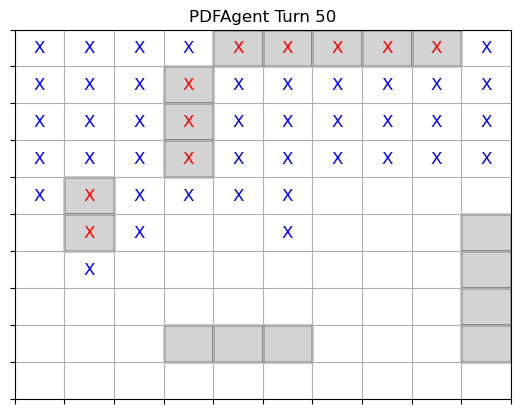

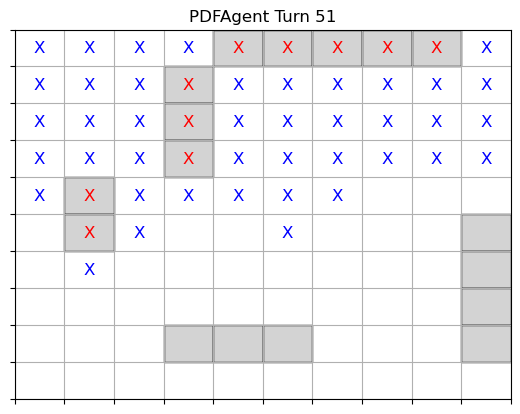

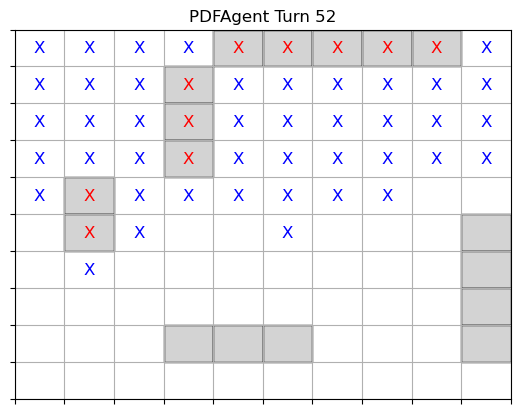

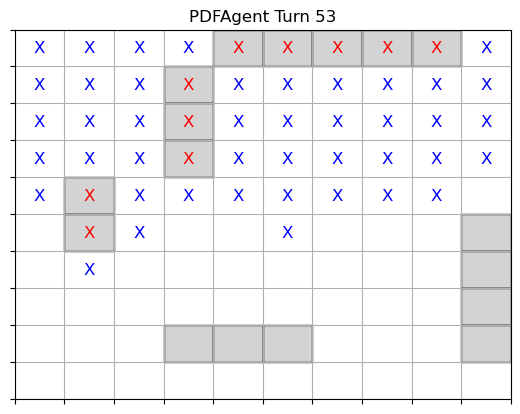

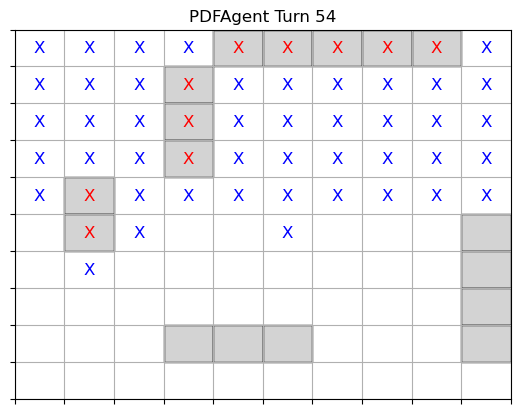

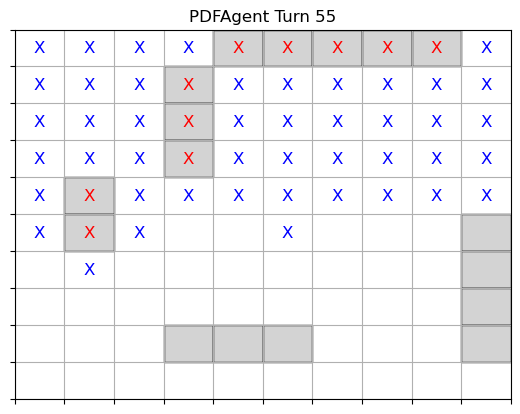

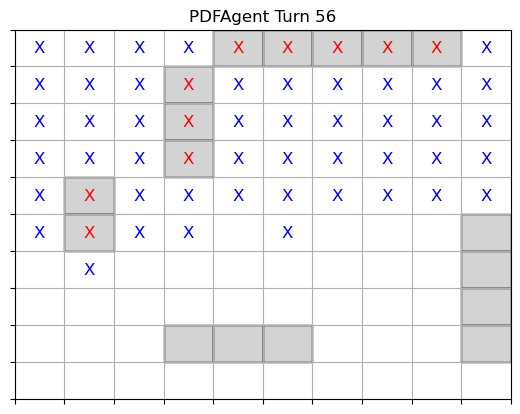

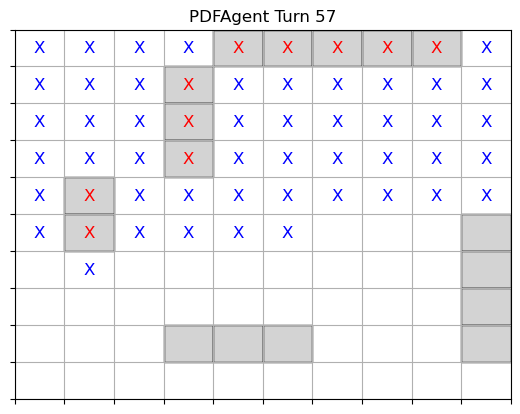

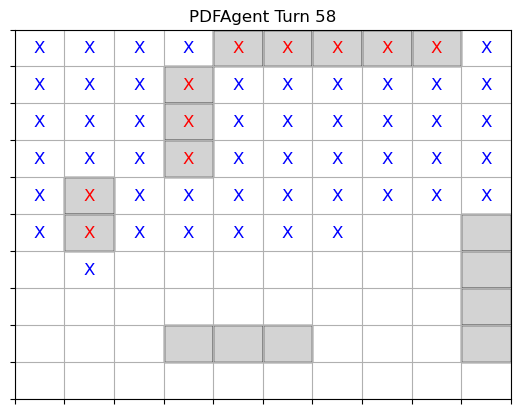

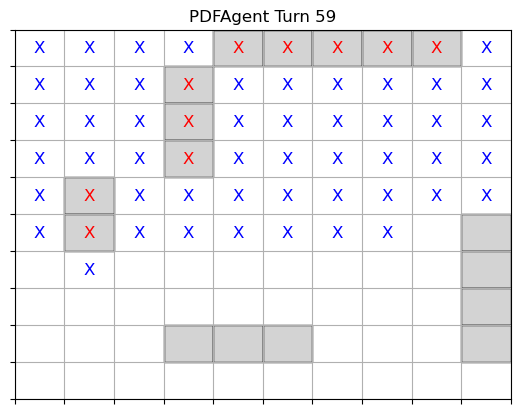

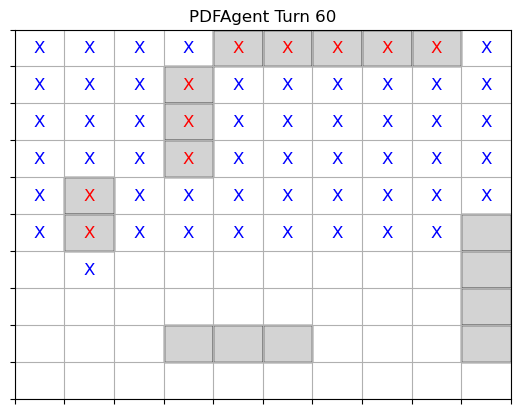

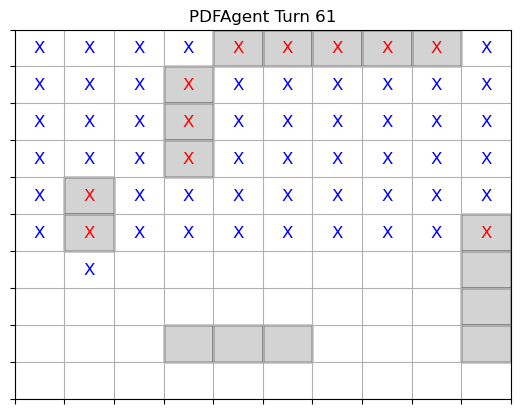

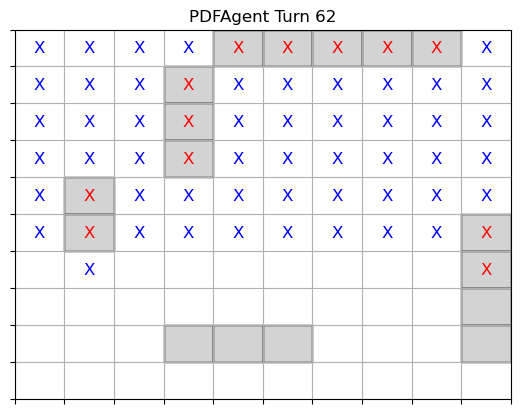

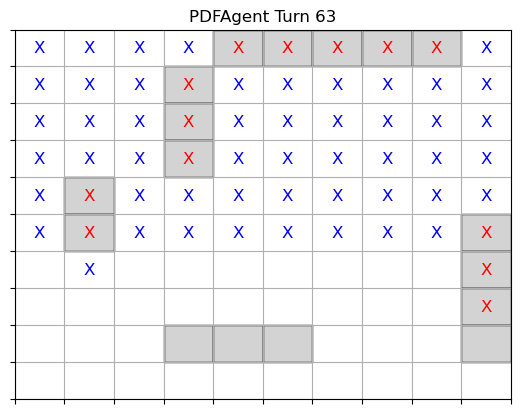

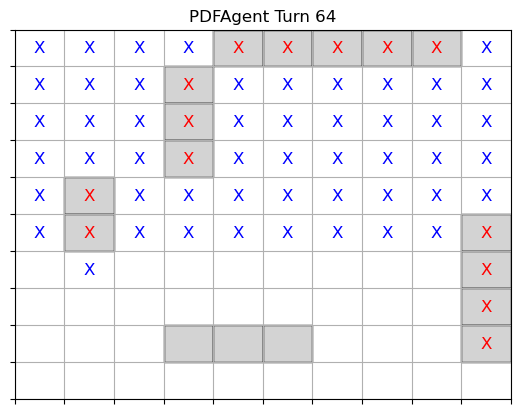

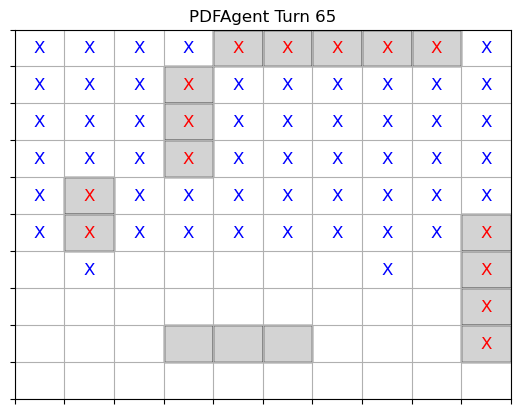

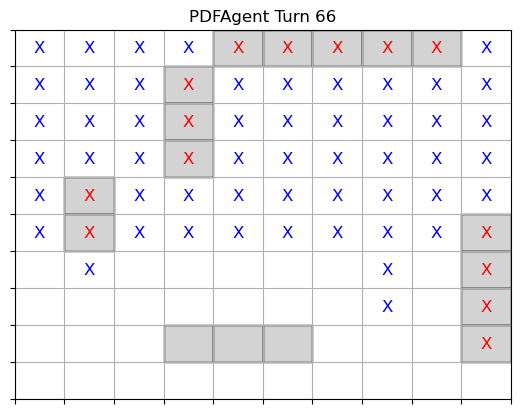

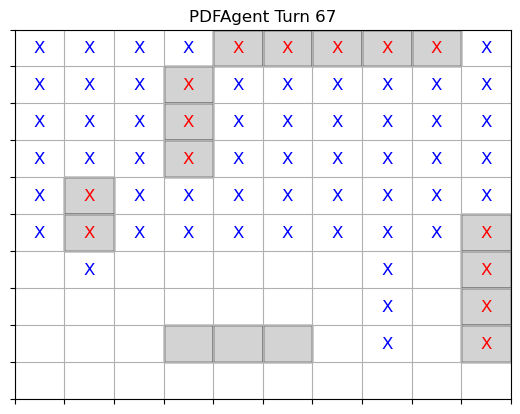

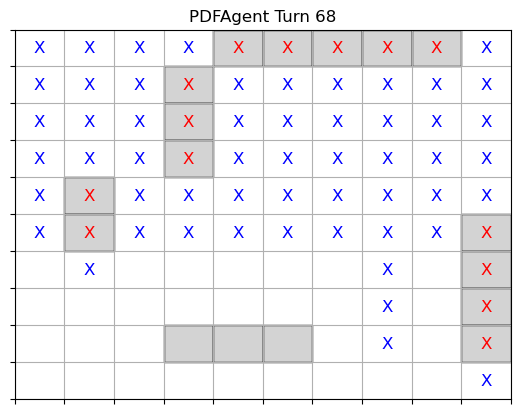

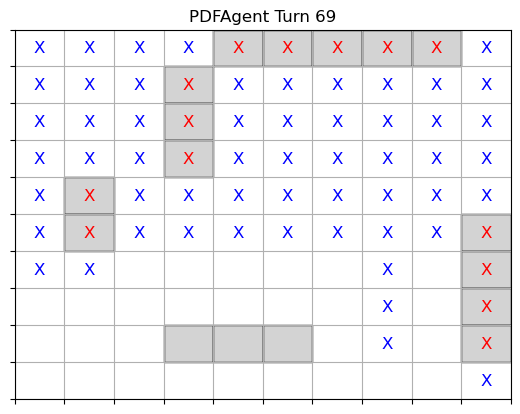

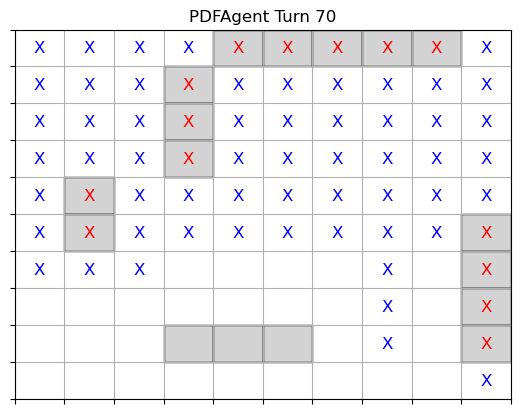

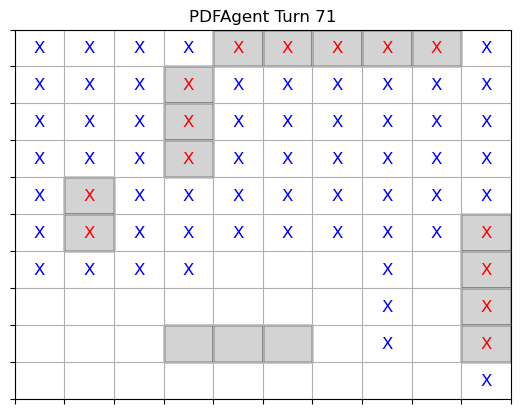

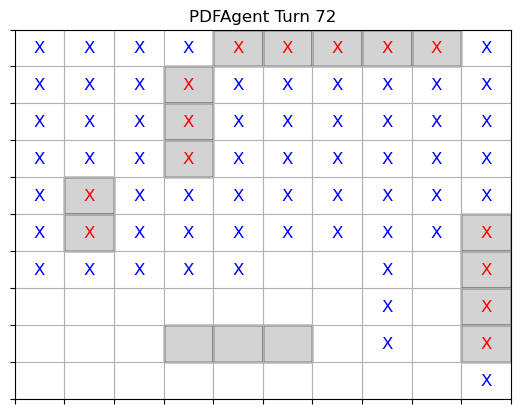

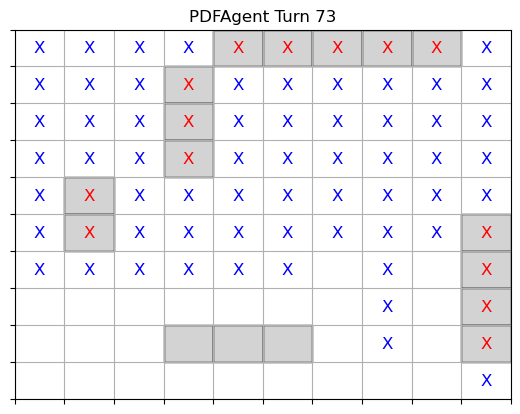

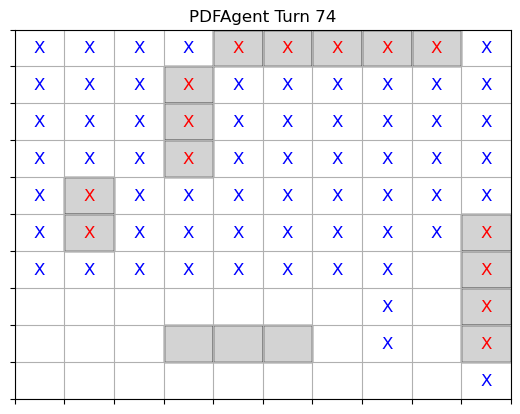

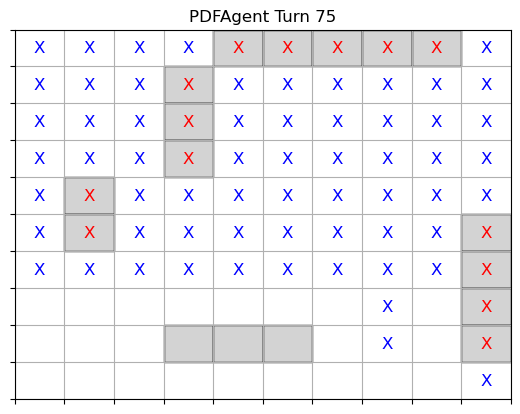

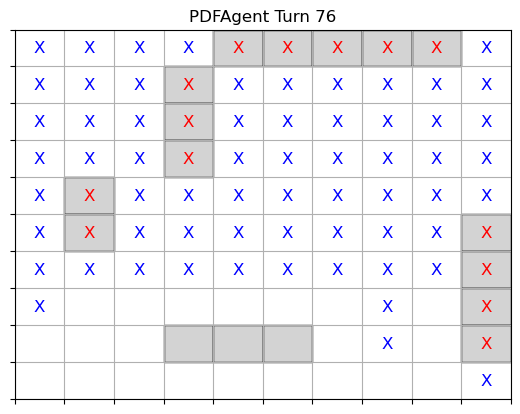

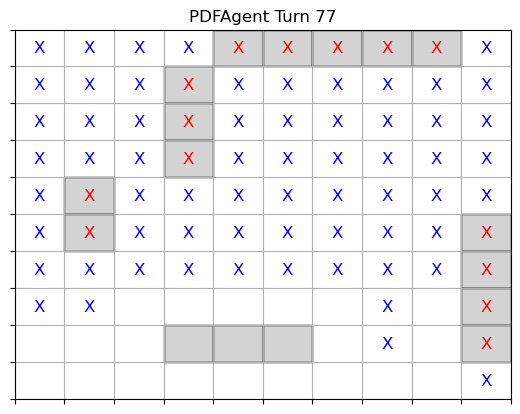

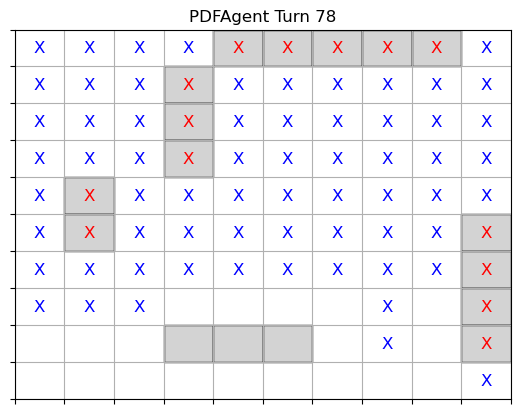

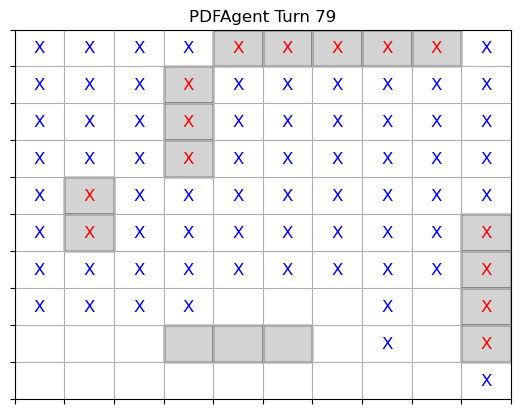

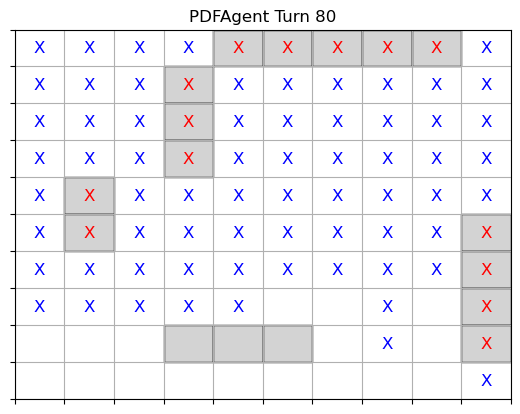

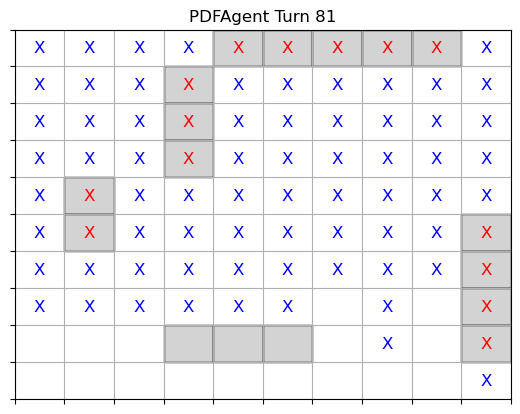

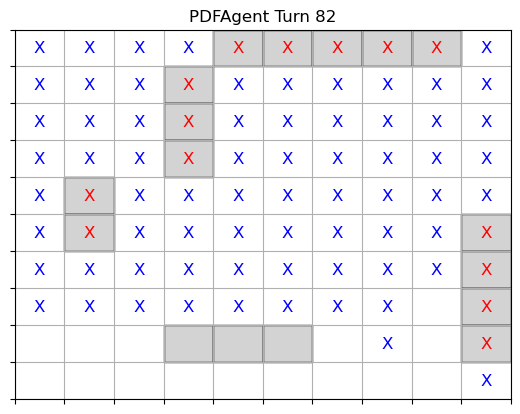

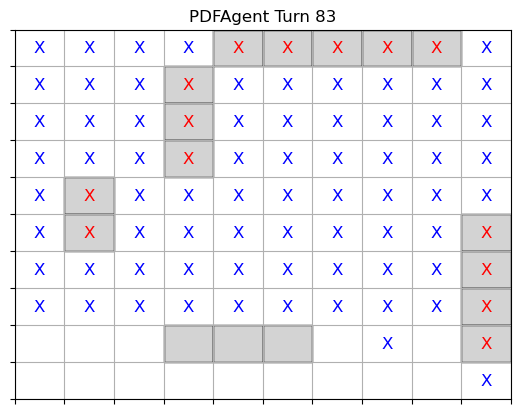

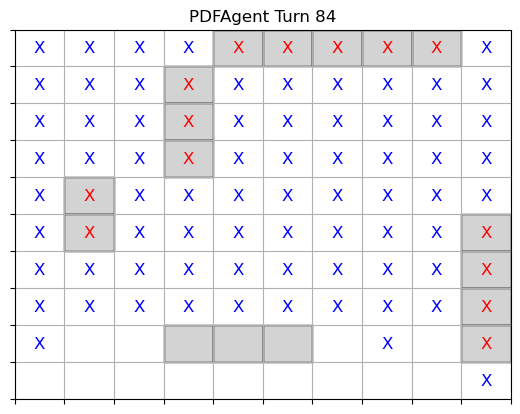

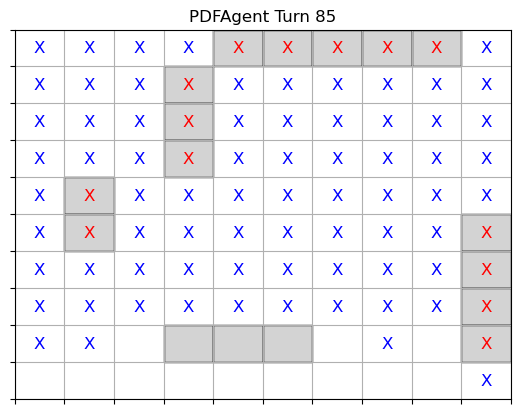

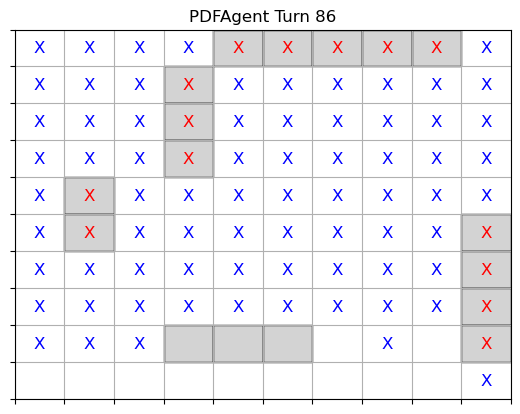

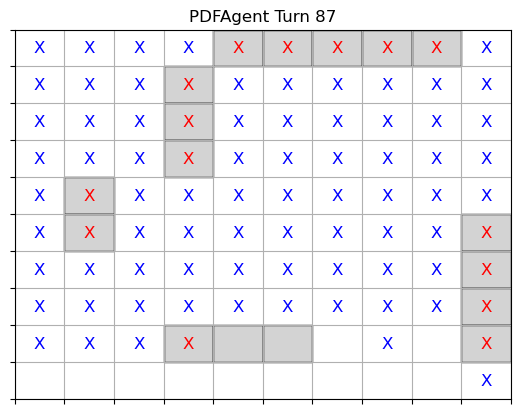

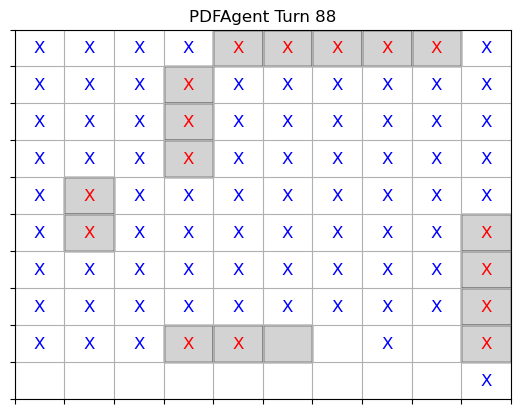

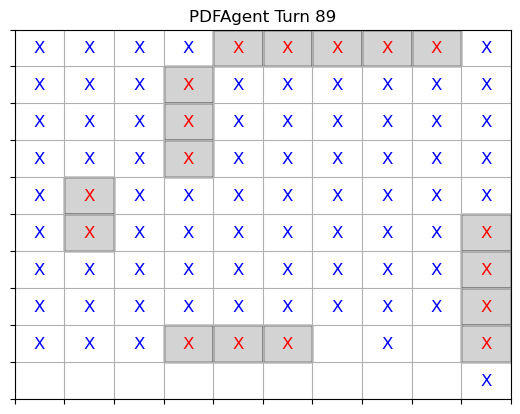

In [109]:
simulate_with_steps(PDFAgent(), show_ships=True, pause=0.1)